<h1>Temperal Processing and RNN Assingment
<h2>Mathai Paul
<h2>GX3081

In [40]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import seaborn as sns
import matplotlib as mpl
from scipy import stats
from itertools import product
import itertools
import warnings
import datetime
%matplotlib inline

In [41]:
# convert series to supervised learning
def series_to_supevised(dataset, n_in=1, n_out=1, dropnan=True):
    num_vars = 1 if type(dataset) is list else dataset.shape[1]
    dataframe = DataFrame(dataset)
    cols, names = list(), list()
    
    # input sequence (t-n, ....t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_vars)]
    # forecast sequence (t, t+1 .... t+n)
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_vars)]
    
    # put it all together 
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [42]:
dataset = read_csv("Dataset.csv")
dataset.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [43]:
col_time=["date"]

col_temp = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]

col_hum = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]

col_weather = ["T_out", "Tdewpoint","RH_out","Press_mm_hg",
                "Windspeed","Visibility"] 
col_light = ["lights"]

col_randoms = ["rv1", "rv2"]

col_target = ["Appliances"]

feature=["RH_out","RH_8","RH_1","T3","RH_3","T2","Press_mm_hg","RH_2","RH_7","T8","RH_6","RH_4","RH_5","T_out","RH_9",
             "T4","T7","Tdewpoint","Windspeed","T1","T5"]

In [44]:
train, test = train_test_split(dataset,test_size=0.113250570053206,random_state=40)
feature_vars = train[ col_time + col_temp + col_hum + col_weather + col_light + col_randoms ]
target_vars = train[col_target]

In [45]:
dataset['WEEKDAY'] = ((pd.to_datetime(dataset['date']).dt.dayofweek)// 5 == 1).astype(float)
# There are 5472 weekend recordings 
dataset['WEEKDAY'].value_counts()

0.0    14263
1.0     5472
Name: WEEKDAY, dtype: int64

In [46]:
# Find rows with weekday 
temp_weekday =  dataset[dataset['WEEKDAY'] == 0]
# To understand the timeseries variation of the applaince energy consumption
visData = go.Scatter( x= temp_weekday.date  ,  mode = "lines", y = temp_weekday.Appliances )
layout = go.Layout(title = 'Appliance energy consumption pattern on weekdays' , xaxis=dict(title='Date'), yaxis=dict(title='(Wh)'))
fig = go.Figure(data=[visData],layout=layout)

iplot(fig)

In [47]:
# Find rows with weekend 

temp_weekend =  dataset[dataset['WEEKDAY'] == 1]

# To understand the timeseries variation of the applaince energy consumption
visData = go.Scatter( x= temp_weekend.date  ,  mode = "lines", y = temp_weekend.Appliances )
layout = go.Layout(title = 'Appliance energy consumption pattern on weekend' , xaxis=dict(title='Date'), yaxis=dict(title='(Wh)'))
fig = go.Figure(data=[visData],layout=layout)

iplot(fig)

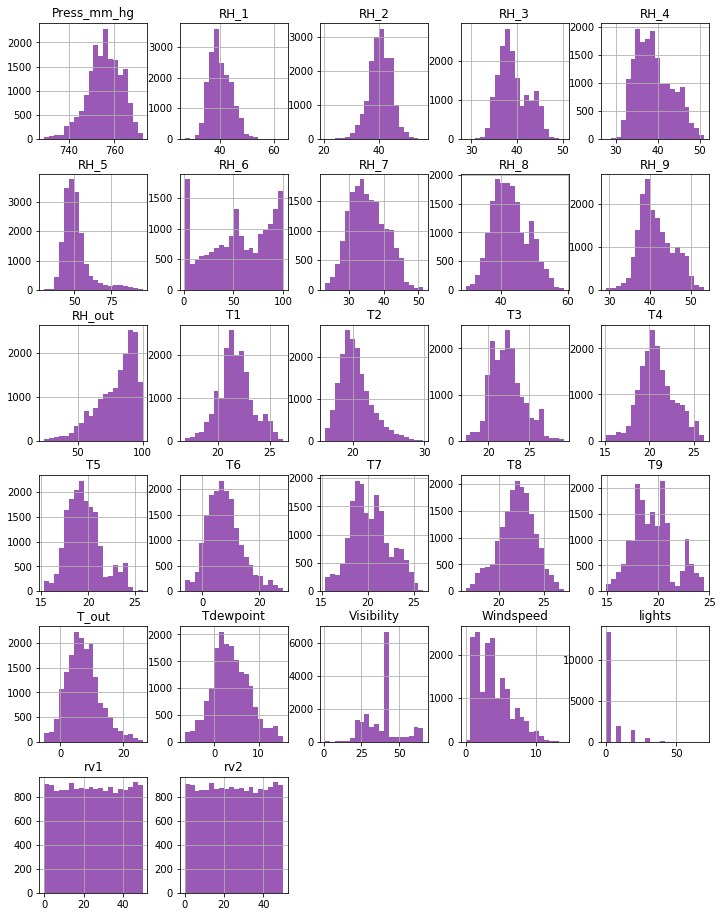

In [48]:
# Histogram of all the features to understand the distribution
feature_vars.hist(bins = 20 , figsize= (12,16)) ;

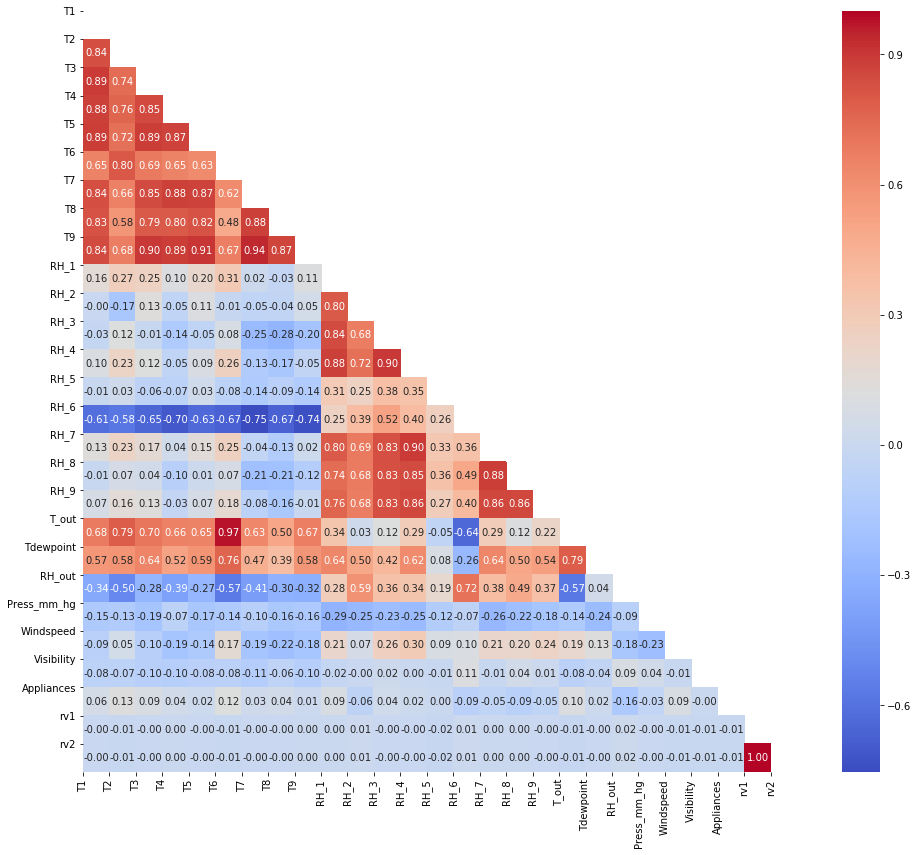

In [49]:
# Use the weather , temperature , applainces and random column to see the correlation
train_corr = train[col_temp + col_hum + col_weather +col_target+col_randoms]
corr = train_corr.corr()
# Mask the repeated values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
  
f, ax = pyplot.subplots(figsize=(16, 14))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, annot=True, fmt=".2f" , mask=mask, cmap='coolwarm'),
    #Apply xticks
pyplot.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
pyplot.yticks(range(len(corr.columns)), corr.columns)
    #show plot
pyplot.show()

/Users/paulmathai/.virtualenvs/keras_tf/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



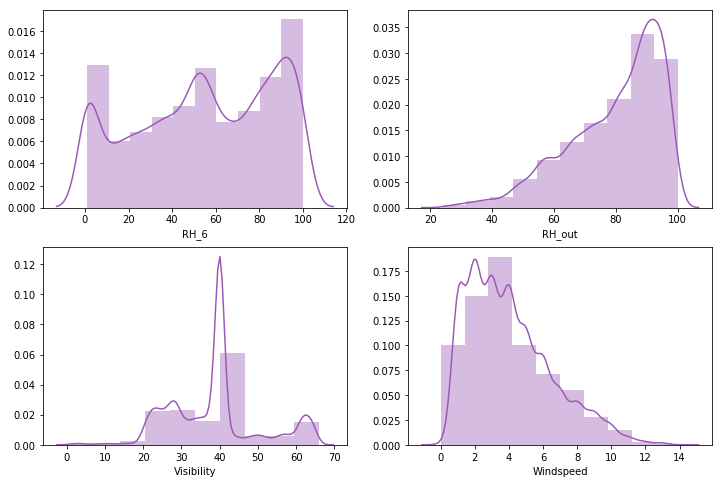

In [50]:
f, ax = pyplot.subplots(2,2,figsize=(12,8))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))
vis1 = sns.distplot(feature_vars["RH_6"],bins=10, ax= ax[0][0])
vis2 = sns.distplot(feature_vars["RH_out"],bins=10, ax=ax[0][1])
vis3 = sns.distplot(feature_vars["Visibility"],bins=10, ax=ax[1][0])
vis4 = sns.distplot(feature_vars["Windspeed"],bins=10, ax=ax[1][1])

In [51]:
data1 = dataset[col_target + col_time + feature]
#data1 = dataset["Appliances","date","RH_out","RH_8","RH_1","T3","RH_3","T2","Press_mm_hg","RH_2","RH_7","T8","RH_6","RH_4","RH_5","T_out","RH_9","T4","T7","Tdewpoint","Windspeed","T1","T5"]
data1["date"]=pd.to_datetime(data1["date"])
data1 = data1.set_index(['date'], drop=True)
values=data1.values
values.shape
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

/Users/paulmathai/.virtualenvs/keras_tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [52]:
reframed = series_to_supevised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43]], axis=1, inplace=True)
print("reframed: ", reframed.shape, "reframed head: ", reframed.head())

# split into train and test sets
values = reframed.values

X = values[:,:21]
Y = values[:,21]
#Y2 = dataset[:,16]  


# Split Data to Train and Test
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.113250570053206)

# reshape input to be 3D [samples, timesteps, features]
X_Train = X_Train.reshape((X_Train.shape[0], 1, X_Train.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))

reframed:  (19734, 23) reframed head:     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.046729   0.894737   0.661412   0.566187   0.215188   0.746066   
2   0.046729   0.894737   0.660155   0.541326   0.215188   0.748871   
3   0.037383   0.894737   0.655586   0.530502   0.215188   0.755569   
4   0.037383   0.894737   0.650788   0.524080   0.215188   0.758685   
5   0.046729   0.894737   0.650788   0.531419   0.215188   0.758685   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var14(t-1)  \
1   0.225345   0.097674   0.684038    0.653428    ...       0.381691   
2   0.225345   0.100000   0.682140    0.651064    ...       0.381691   
3   0.225345   0.102326   0.679445    0.646572    ...       0.380037   
4   0.225345   0.104651   0.678414    0.641489    ...       0.380037   
5   0.225345   0.106977   0.676727    0.639362    ...       0.380037   

   var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  var19(t-1)  var20(t-1)  \
1    0.372990    0.67729

In [53]:
# network architecture
model = Sequential()
model.add(LSTM(50, input_shape=(X_Train.shape[1], X_Train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq = 2000)
# fit
history = model.fit(X_Train, Y_Train, epochs=70, batch_size=10, validation_data=(X_Test, Y_Test), verbose=1, shuffle=False, callbacks=[tensorboard_callback])

Train on 17499 samples, validate on 2235 samples
Epoch 1/70
17499/17499 [==============================] - 5s 282us/sample - loss: 0.0053 - val_loss: 0.0034
Epoch 2/70
17499/17499 [==============================] - 3s 161us/sample - loss: 0.0035 - val_loss: 0.0031
Epoch 3/70
17499/17499 [==============================] - 3s 181us/sample - loss: 0.0034 - val_loss: 0.0030
Epoch 4/70
17499/17499 [==============================] - 3s 160us/sample - loss: 0.0032 - val_loss: 0.0028
Epoch 5/70
17499/17499 [==============================] - 3s 161us/sample - loss: 0.0030 - val_loss: 0.0027
Epoch 6/70
17499/17499 [==============================] - 3s 172us/sample - loss: 0.0028 - val_loss: 0.0025
Epoch 7/70
17499/17499 [==============================] - 3s 164us/sample - loss: 0.0027 - val_loss: 0.0024
Epoch 8/70
17499/17499 [==============================] - 3s 162us/sample - loss: 0.0026 - val_loss: 0.0024
Epoch 9/70
17499/17499 [==============================] - 3s 165us/sample - loss: 0.002

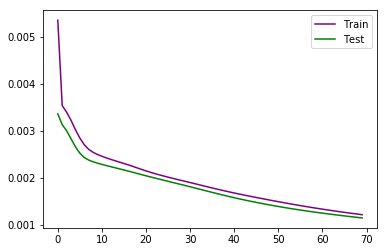

In [57]:
pyplot.plot(history.history['loss'], label='Train',color = 'purple')
pyplot.plot(history.history['val_loss'], label='Test',color = 'green')
pyplot.legend()
pyplot.show()

In [58]:
lstm_test_mse = model.evaluate(X_Test, Y_Test, batch_size=1, verbose = 0)
print('Test MSE: %f'%lstm_test_mse)

Test MSE: 0.001147


In [59]:
from sklearn.metrics import r2_score

y_pred_test_lstm = model.predict(X_Test)
y_train_pred_lstm = model.predict(X_Train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_Train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_Test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.963
The R2 score on the Test set is:	0.964


In [60]:
pred = model.predict(X_Test, batch_size=10)
pred

array([[0.38573104],
       [0.4928149 ],
       [0.77972734],
       ...,
       [0.43163216],
       [0.4987365 ],
       [0.4583431 ]], dtype=float32)

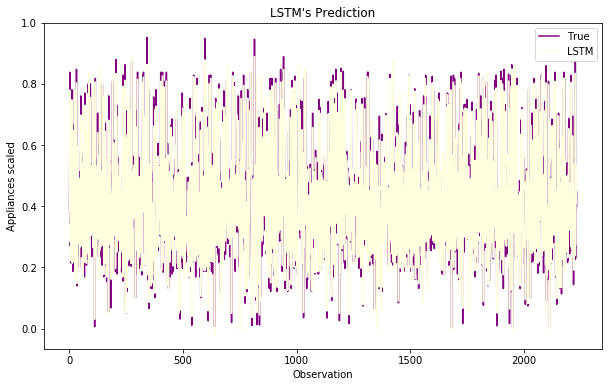

In [66]:
pyplot.figure(figsize=(10, 6))
pyplot.plot(Y_Test, label='True',color = 'purple')
pyplot.plot(pred, label='LSTM',color = 'lightyellow')
pyplot.title("LSTM's Prediction")
pyplot.xlabel('Observation')
pyplot.ylabel('Appliances scaled')
pyplot.legend()
pyplot.show();

In [67]:
df = pd.read_csv("Dataset.csv")
# time to conversion
df.Timestamp = pd.to_datetime(df.date)

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

/Users/paulmathai/.virtualenvs/keras_tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



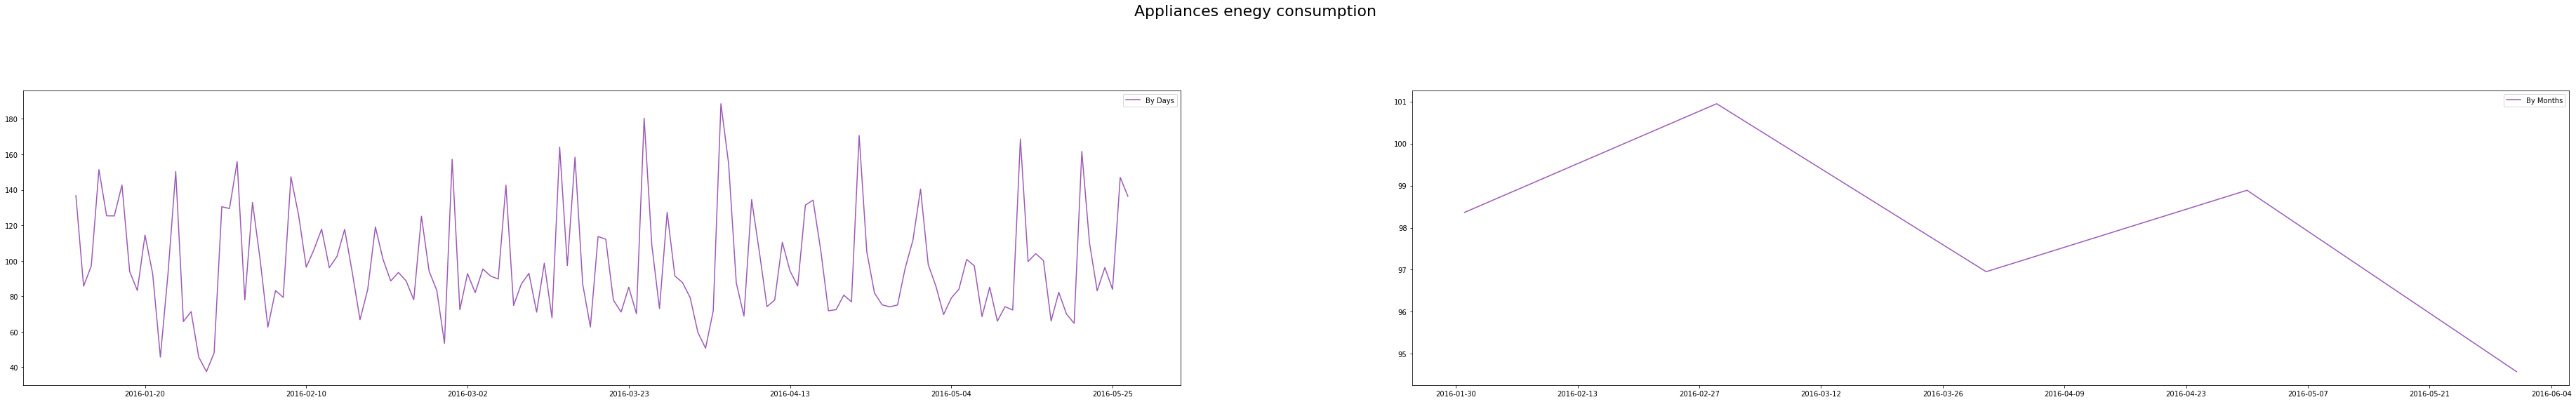

In [68]:
fig = pyplot.figure(figsize=[65, 17])
pyplot.suptitle('Appliances enegy consumption', fontsize=22)

pyplot.subplot(221)
pyplot.plot(df.Appliances, '-', label='By Days')
pyplot.legend()

pyplot.subplot(222)
pyplot.plot(df_month.Appliances, '-', label='By Months')
pyplot.legend()

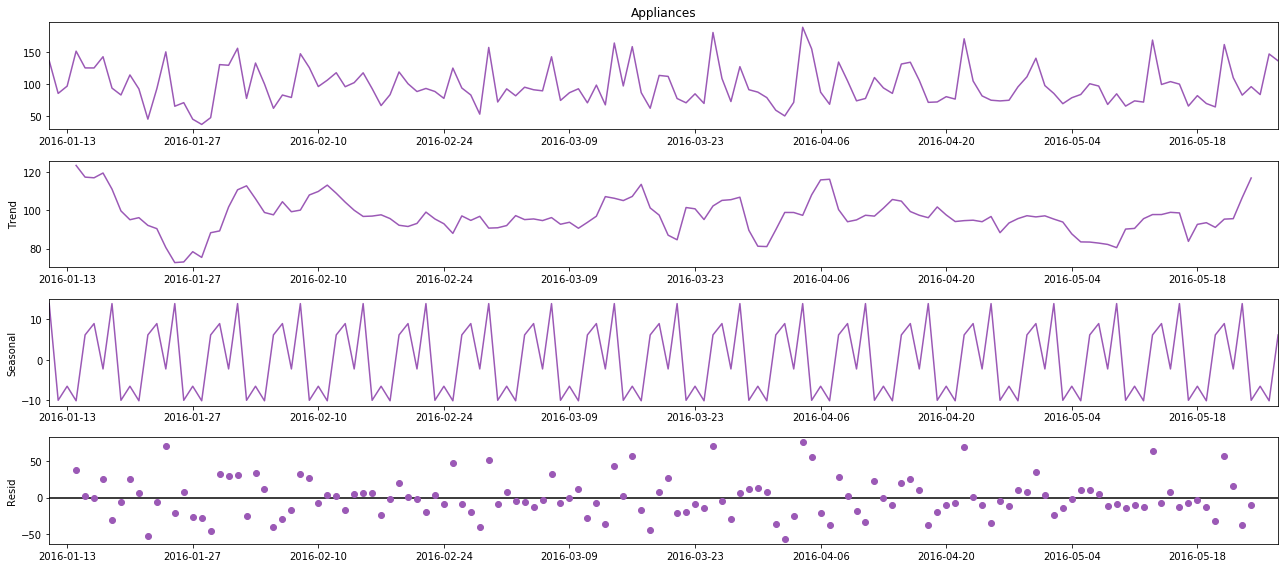

In [69]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df.Appliances, model='additive')
fig = decomposition.plot()
pyplot.show()

In [70]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [71]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df.Appliances,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1658.7532763969257
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1428.6726154060407
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1313.1647659320902
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1106.9819680495827
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1318.1457992688975
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1246.8123896151799
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1152.4882411221831
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1108.9482703351582
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1541.3587631153282
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1359.5348550786794
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1300.6379936358292
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1097.6124476468349
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1315.2894811470858
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1237.244715071837
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1154.3111338863398
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1099.5876717236672
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1393.4310643175716
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1273.7778863

In [72]:
mod = sm.tsa.statespace.SARIMAX(df.Appliances,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1213      0.112      1.088      0.277      -0.097       0.340
ma.L1         -1.0000    669.795     -0.001      0.999   -1313.775    1311.775
ar.S.L12      -0.1071      0.137     -0.783      0.434      -0.375       0.161
ma.S.L12      -1.0000    669.786     -0.001      0.999   -1313.756    1311.756
sigma2       921.5928      0.667   1380.778      0.000     920.285     922.901


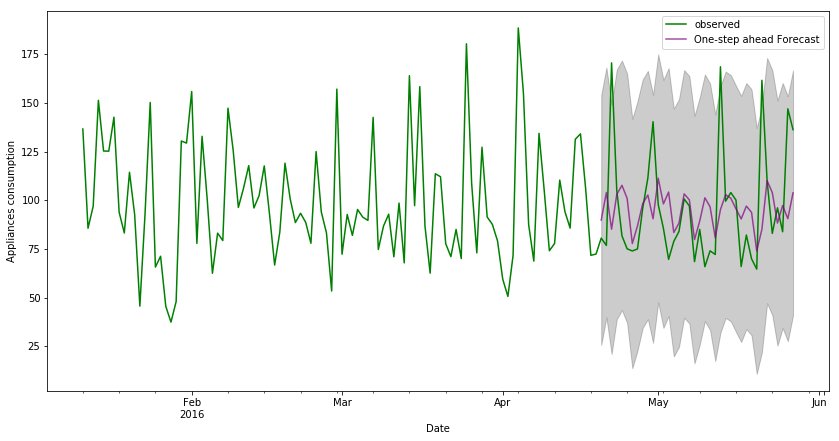

In [86]:
pred = results.get_prediction(start=pd.to_datetime('2016-04-20'), dynamic=False)
pred_ci = pred.conf_int()

ax = df.Appliances['2016':].plot(label='observed', color = 'green')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7),color = 'purple')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Appliances consumption')
pyplot.legend()

pyplot.show()

In [87]:
y_forecasted = pred.predicted_mean
y_truth = df.Appliances['2016-04-20':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 879.68
The Root Mean Squared Error of our forecasts is 29.66


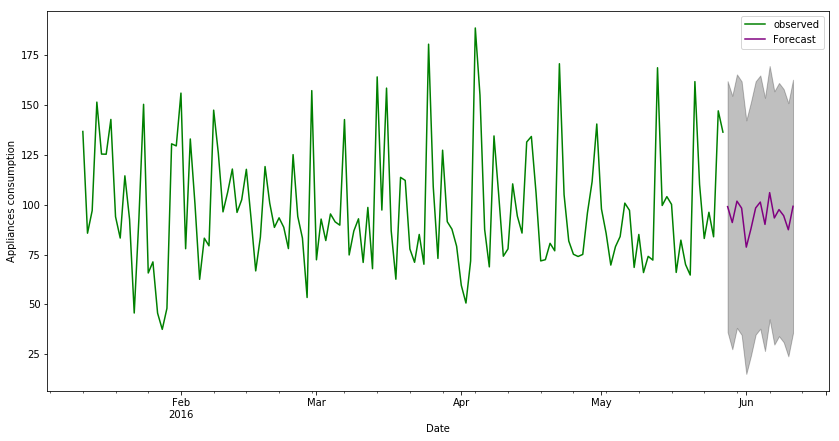

In [89]:
pred_uc = results.get_forecast(steps=15)
pred_ci = pred_uc.conf_int()

ax = df.Appliances.plot(label='observed', figsize=(14, 7),color = 'green')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color = 'purple')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Appliances consumption')

pyplot.legend()
pyplot.show()